In [1]:
!pip install keras_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

os.environ["KERAS_BACKEND"] = "torch"
import keras_core as keras

Using PyTorch backend.


# The Perceptron and beyond

In this section, we consider a regression task where the underlying data generation process is as follows:
$$ y = - \sin{(0.8 * x)}$$

Note that in this example there is no noise in the data, a case that you will rarely encounter in practice.

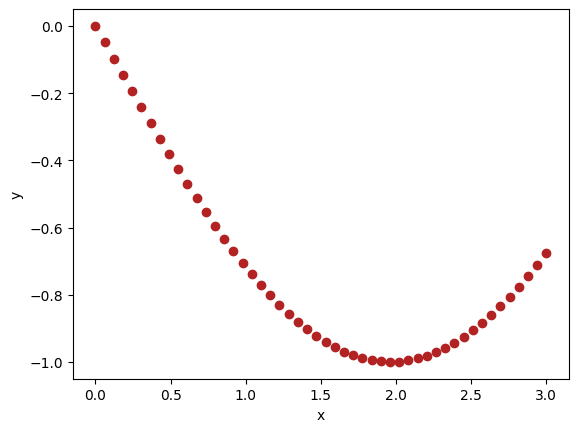

In [3]:
# Defining our dataset

x_train = np.linspace(0, 3, 50)
y_train = - np.sin(0.8*x_train)

# Plotting the dataset

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color= "firebrick")
plt.show()

The following function can be used to instantiate the perceptron

In [4]:
def perceptron(input_shape= [1], units= 1, activation= None):
    model = keras.Sequential(
        [
            keras.layers.Input(shape= input_shape),
            keras.layers.Dense(units= units, activation= activation)
        ]
    )
    return model

linear_model = perceptron()

# You can vizualize a summary of your model by commenting out the following line.
# Here it is an affine function in dimension 1, thus having two parameters.

# linear_model.summary()

To fit a model in keras, one must first compile it, that is specify the loss and optimizer. Here they are respectively chosen as the mean squared error and gradient descent. Observe that the batch size is the same as the size of the training dataset, resulting in batch gradient descent.

You can play with the learning rate and number of epochs to understand how the training algorithm behaves.

In [ ]:
linear_model.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.SGD(learning_rate= 0.2)
)
history = linear_model.fit(x_train, y_train, epochs= 35, batch_size= 50)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(history.history['loss'])
plt.show()

Having trained the model, we can now use it in prediction.

In [ ]:
y_pred_linear = linear_model.predict(x_train)

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color='firebrick', label= 'true function')
plt.plot(x_train, y_pred_linear, color= 'teal', label= 'linear model')
plt.legend()
plt.show()

Beyond this simple perceptron, we now consider a 2-layers neural network model.

In [ ]:
def neural_net_2layers(input_shape= [1], units= 16, activation= 'sigmoid'):
    model = keras.Sequential(
        [
            keras.layers.Input(shape= input_shape),
            keras.layers.Dense(units= units, activation= activation),
            keras.layers.Dense(units= 1)
        ]
    )
    return model

You can train the model, and play with the hyperparameters to answer the questions.

In [ ]:
net = neural_net_2layers(units= 10)

net.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate= 0.1)  # Try also the (batch) SGD optimizer
)

history = net.fit(x_train, y_train, epochs= 300, batch_size= 25, verbose= 0)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(np.log(history.history['loss']))
plt.show()

In [ ]:
y_pred_2l = net.predict(x_train)

plt.figure()
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_train, y_train, color='firebrick', label = 'true function')
plt.plot(x_train, y_pred_linear, color= 'teal', label = 'linear model')
plt.plot(x_train, y_pred_2l, color= 'indigo', label = '2-l net')
plt.legend()
plt.show()

# In the wild jungle of training algorithms

## Small model

We first start by defining a simple dataset based on a modified cosine surface. This will allows us to test small models, and in particular 2nd order optimization algorithms. While <tt>keras</tt> is high-level deep learning library, we will dive into the depths of <tt>pytorch</tt> to have more control over the optimization schemes.

In [ ]:
def f(x, y):
    return(torch.sin(0.8*(x**2 + y**2)) / (x**2 + y**2)**(0.9))

noise_level = 0
mesh_size = 40
t = torch.linspace(-3, 3, mesh_size)
x, y = torch.meshgrid(t, t)
z = f(x, y)
z_noisy = z + noise_level * torch.randn(mesh_size, mesh_size)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z_noisy,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()


# dataset creation
x_train = torch.vstack([x.ravel(), y.ravel()]).T
y_train = z_noisy.ravel()
y_test = z.ravel()

The following class encodes the architecture of a neural network with two hidden layers, for when the input data is 2-dimensional. We provide a simplified <tt>fit</tt> method to train the neural network. You are encouraged to understand the code, and what executing the functions will return so as to draw legitimate conclusions about the experiments.

In [ ]:
class Net3L(nn.Module):

    def __init__(self, n_neurons_l1= 10, n_neurons_l2= 10):
        super(Net3L, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, n_neurons_l1),
            nn.ReLU(),
            nn.Linear(n_neurons_l1, n_neurons_l2),
            nn.ReLU(),
            nn.Linear(n_neurons_l2, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

    def fit(self, x_train, y_train, optimizer, batch_size, n_epochs_max):
        # Instantiate the train loader
        train_data = TensorDataset(x_train, y_train)
        train_loader = DataLoader(dataset =train_data, batch_size= batch_size, shuffle= True)
        # Beginning the optimization algorithm
        loss_list = []
        for n_epochs in range(n_epochs_max):
            # We train for a fixed number of epochs
            for x_batch, y_batch in train_loader:
                def closure():
                    optimizer.zero_grad()
                    output = self.forward(x_batch)
                    loss = nn.MSELoss()(output.squeeze(-1), y_batch)
                    loss.backward()
                    return loss
                loss = optimizer.step(closure)
            loss_list.append(loss.item())
        return loss_list

    def evaluate(self, x_test, y_test):
      y_pred = self(x_test).squeeze(-1)
      return (nn.MSELoss()(y_pred, y_test)).item()

The cell below gives an example of what happens when the training is done using the L-BFGS algorithm. It can be adapted to other algorithms by modifying the arguments passed to the <tt>fit</tt> method.

In [ ]:
net = Net3L(50, 50)
loss_list = net.fit(x_train, y_train, torch.optim.LBFGS(net.parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe'), 1600, 2000)

plt.figure()
plt.xlabel('Epoch number')
plt.ylabel('Training MSE')
plt.plot(loss_list)
plt.show()

y_pred = net(x_train).detach().squeeze(-1)

fig, ax = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'})
#
ax[0].plot_trisurf(x_train[:, 0], x_train[:, 1], y_pred, vmin=y_train.min(), cmap=cm.viridis)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_zlabel('z')
ax[0].set_title('Surface')
#
ax[1].plot_trisurf(x_train[:, 0], x_train[:, 1], (y_pred-y_train)**2, vmin=0, cmap=cm.viridis)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_zlabel('z')
ax[1].set_title('Squared residuals')
plt.show()

print('Training error:', net.evaluate(x_train, y_train))
print('Test error:', net.evaluate(x_train, y_test))

In [ ]:
# Example with a list of optimizers (running this cell takes ~5min with the default parameters)
net = Net3L(50, 50)
# We create copies of this net so that every optimizer starts with the same initialization.
net_list = [copy.deepcopy(net) for i in range(5)]
# The number of epochs and other hyperparameters can (and should) be adapted to the point you're trying to make.
n_epochs = 2500
optim1 = torch.optim.SGD(params=net_list[0].parameters(), lr=0.05)
optim2 = torch.optim.SGD(params=net_list[1].parameters(), lr=0.1)
optim3 = torch.optim.SGD(params=net_list[2].parameters(), lr=0.1, momentum=0.9, nesterov= True)
optim4 = torch.optim.Adam(params=net_list[3].parameters())
optim5 = torch.optim.LBFGS(params=net_list[4].parameters(), lr=1, max_iter=1, line_search_fn='strong_wolfe')

optimizer_list = [optim1, optim2, optim3, optim4, optim5]
batch_sizes_list = [1600, 40, 400, 400, 1600]
times_list = []
loss_meta_list = []
eval_list = []

for i, optimizer in enumerate(optimizer_list):
    t0 = time.time()
    loss_list = net_list[i].fit(x_train, y_train, optimizer= optimizer, batch_size= batch_sizes_list[i], n_epochs_max= n_epochs)
    t1 = time.time()
    times_list.append(t1-t0)
    loss_meta_list.append(loss_list)
    eval_list.append(net_list[i].evaluate(x_train, y_test))


In [ ]:
colors = cm.tab10(torch.linspace(0, 1, 5))
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Training MSE')
for i in range(5):
    plt.plot(loss_meta_list[i], color= colors[i])
plt.legend([f"optim{i+1}: {round(times_list[i], 2)}s" for i in range(5)])
plt.show()
print('Training times:', [f"optim{i+1}: {times_list[i]:.2f}s" for i in range(5)])
print('Evaluation performances:', [f"optim{i+1}: {eval_list[i]:1.3e}" for i in range(5)])

## Towards a bigger model

We now switch to a bigger model, used to perform classification over the MNIST dataset. This example is widely known in the machine learning community, and we follow the code in the footsteps of François Chollet, the creator of the <tt>keras</tt> library (https://keras.io/examples/vision/mnist_convnet/).

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)


The following cell deals with the training of the model. Can you change the optimizer while still retaining the capabilities of the model trained with adam ?

In [ ]:
batch_size = 128
epochs = 15

# Modify the optimizer here
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


# A personal regression example


For this exercise, you will work on a dataset that is built from your personal student number as indicated in the assignment. If you have trouble with loading the data, place the data.csv file in your working directory.

In [ ]:
try:
  data = pd.read_csv("data.csv", header= None).values.T
  print("Succesfully loaded data")
except:
  try:
    data_url = "https://github.com/KULasagna/ANN_DL_public/blob/master/session1/data.csv?raw=true"
    data = pd.read_csv(data_url, header= None).values.T
    print("Succesfully loaded data")
  except:
    print(f"Please download the data.csv file from Toledo and place it in your working directory: {os.getcwd()}")

In [ ]:
def dataset_generation(d1, d2, d3, d4, d5):
    T_new = (d1 * data[:, 2] + d2 * data[:, 3] + d3 * data[:, 4] + d4 * data[:, 5] + d5 * data[:, 6])/(d1 + d2 + d3 + d4 + d5)
    return T_new

x_values = data[:, 0:2]

# Put your own (decreasingly ordered) student number in the function
# e.g. u1024659 --> T_new =  dataset_generation(9, 6, 5, 4, 2)

T_new =  dataset_generation(1, 1, 1, 1, 1)

# Random subsampling to get the working dataset
idx = np.random.permutation(13600)

# training set
x_train = x_values[idx[0:2000]]
y_train = T_new[idx[0:2000]]

# test set
x_test = x_values[idx[2000:3000]]
y_test = T_new[idx[2000:3000]]


print('Number of training datapoints:', x_train.shape[0])
print('Number of testing datapoints:', x_test.shape[0])

You can now plot the surface of the dataset. (Hint: use the function <tt> plot_trisurf </tt>)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
# TODO
plt.show()


In the following, we give an example of how to train a model. When you train yours, do not forget to validate it ! Hint: it is not enough to look at the training error. The hyperparameter values have voluntarily be set to give suboptimal results, you can do better than the proposed architecture !

In [ ]:
net = keras.Sequential(
        [
            keras.layers.Input(shape= [x_train.shape[1]]),
            keras.layers.Dense(units= 3, activation='tanh'),
            keras.layers.Dense(units= 1)
        ]
    )

net.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate= 0.05)
)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = net.fit(x_train, y_train, validation_split= 0.2, epochs= 20, batch_size= 64, callbacks= [callback], verbose= 0)

plt.figure()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.plot(history.history['loss'], color= "firebrick")
plt.plot(history.history['val_loss'], color= 'teal')
plt.show()
print('Last training error:', history.history['loss'][-1])
print('Last validation error:', history.history['val_loss'][-1])

Once a model is trained, you can use it to assess the final performance of the model on the test set.

In [ ]:
y_pred = net.predict(x_test).squeeze(-1)
print('Final test error:', 0.5*((y_pred - y_test)**2).mean())